# Explore technique for matching MSOAs

## Set-up

### Packages and file paths

In [1]:
# Import required packages
from dataclasses import dataclass
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# File paths
@dataclass(frozen=True)
class Paths:
    '''Stores paths to data and files'''

    area_data = '../data/area_data'
    england_wales_shp = 'MSOA_2021_EW_BFC_V6.zip'
    imd = 'imd2019_msoa_level_data.csv'
    ruc = 'rural_urban_classification_2011_small_area_geographies.ods'
    ruc_msoa = 'rural_urban_classification_2011_msoa.csv'


paths = Paths()

## Import data

### Import shapefile

In [3]:
# Import shapefile of England and Wales
shp_full = gpd.read_file(os.path.join(paths.area_data, paths.england_wales_shp))

### Import IMD

In [4]:
imd_full = pd.read_csv(os.path.join(paths.area_data, paths.imd))
imd_full.head()

MSOAC            MSOAHOCLN     LAD19C                LAD19N     REG  \
0  E02000001       City of London  E09000001        City of London  London   
1  E02000002           Marks Gate  E09000002  Barking and Dagenham  London   
2  E02000003  Chadwell Heath East  E09000002  Barking and Dagenham  London   
3  E02000004         Eastbrookend  E09000002  Barking and Dagenham  London   
4  E02000005      Becontree Heath  E09000002  Barking and Dagenham  London   

   LSOACOUNT  POPMID15  IMD19 SCORE  MSOARANK  MSOADECILE  MSOAQUINTILE  
0          6      6687    14.720484      4198           7             4  
1          4      7379    34.767560      1060           2             1  
2          6     10720    25.149726      2200           4             2  
3          4      6536    23.560044      2429           4             2  
4          5      9243    30.212965      1519           3             2

In [5]:
# Rename and filter columns
new_names = {
    'MSOAC': 'msoa_code',
    'LAD19N': 'local_authority',
    'IMD19 SCORE': 'imd_score',
    'MSOARANK': 'imd_msoa_rank',
    'MSOADECILE': 'imd_msoa_decile',
    'MSOAQUINTILE': 'imd_msoa_quintile'
}
imd = imd_full.rename(columns=new_names)
imd = imd[new_names.values()]
imd.head()

msoa_code       local_authority  imd_score  imd_msoa_rank  imd_msoa_decile  \
0  E02000001        City of London  14.720484           4198                7   
1  E02000002  Barking and Dagenham  34.767560           1060                2   
2  E02000003  Barking and Dagenham  25.149726           2200                4   
3  E02000004  Barking and Dagenham  23.560044           2429                4   
4  E02000005  Barking and Dagenham  30.212965           1519                3   

   imd_msoa_quintile  
0                  4  
1                  1  
2                  2  
3                  2  
4                  2

### Import RUC

In [6]:
# Original import - saved as csv and import that as otherwise takes 1m40s
# ruc = pd.read_excel(os.path.join(paths.data, paths.ruc),
#                     sheet_name='MSOA11', skiprows=[0,1])
# ruc.to_csv(os.path.join(paths.data, paths.ruc_msoa), index=False)

ruc_full = pd.read_csv(os.path.join(paths.area_data, paths.ruc_msoa))
ruc_full.head()

Middle Super Output Area 2011 Code Middle Super Output Area 2011 Name  \
0                          E02000001                 City of London 001   
1                          E02000002           Barking and Dagenham 001   
2                          E02000003           Barking and Dagenham 002   
3                          E02000004           Barking and Dagenham 003   
4                          E02000005           Barking and Dagenham 004   

  Rural Urban Classification 2011 code  \
0                                   A1   
1                                   A1   
2                                   A1   
3                                   A1   
4                                   A1   

  Rural Urban Classification 2011 (10 fold)  \
0                  Urban major conurbation    
1                  Urban major conurbation    
2                  Urban major conurbation    
3                  Urban major conurbation    
4                  Urban major conurbation    

  Rural Urban Classification 2011 (2 fold)  
0                                    Urban  
1                                    Urban  
2                                    Urban  
3                                    Urban  
4                                    Urban

The classification is either as rural or urban, as as one of 8 classes. It is a statistical classification based on population density profiles, and then whether they are in a sparse setting (based on the density profiles in the surrounding areas).

In [7]:
print(ruc_full['Rural Urban Classification 2011 (10 fold)'].drop_duplicates())
print(ruc_full['Rural Urban Classification 2011 (2 fold)'].drop_duplicates())

0                              Urban major conurbation 
159                               Urban city and town  
477                              Rural town and fringe 
1470                            Urban minor conurbation
1496                        Rural village and dispersed
2824    Rural village and dispersed in a sparse setting
3836         Rural town and fringe in a sparse setting 
3915           Urban city and town in a sparse setting 
Name: Rural Urban Classification 2011 (10 fold), dtype: object
0      Urban
477    Rural
Name: Rural Urban Classification 2011 (2 fold), dtype: object


In [8]:
# Rename and filter columns
new_names = {
    'Middle Super Output Area 2011 Code': 'msoa_code',
    'Middle Super Output Area 2011 Name': 'msoa_name',
    'Rural Urban Classification 2011 (2 fold)': 'ruc_2',
    'Rural Urban Classification 2011 code': 'ruc_8_code'}
ruc = ruc_full.rename(columns=new_names)
ruc = ruc[new_names.values()]

# Add the local authorities
ruc['local_authority'] = ruc['msoa_name'].str[:-4]

ruc.head()

msoa_code                 msoa_name  ruc_2 ruc_8_code       local_authority
0  E02000001        City of London 001  Urban         A1        City of London
1  E02000002  Barking and Dagenham 001  Urban         A1  Barking and Dagenham
2  E02000003  Barking and Dagenham 002  Urban         A1  Barking and Dagenham
3  E02000004  Barking and Dagenham 003  Urban         A1  Barking and Dagenham
4  E02000005  Barking and Dagenham 004  Urban         A1  Barking and Dagenham

## Filter shapefile to relevant areas

In [9]:
def preview_gpd(df):
    '''
    Using the provided Geopandas dataframe, view the local authorities present,
    the head of the dataframe and a simple map of the data
    '''
    # List the local authorities present
    print(df['MSOA21NM'].str[:-4].sort_values().drop_duplicates())

    # Preview the dataframe
    display(df.head())

    # Create simple plot of the data
    fig, ax = plt.subplots()
    df.plot(ax=ax)
    ax.set_axis_off()

4000    North Devon
4052       Torridge
Name: MSOA21NM, dtype: object


MSOA21CD         MSOA21NM   BNG_E   BNG_N     LONG      LAT  \
4000  E02004175  North Devon 001  253249  146186 -4.10168  51.1960   
4001  E02004176  North Devon 002  266976  146638 -3.90550  51.2034   
4002  E02004177  North Devon 003  250974  146005 -4.13414  51.1938   
4003  E02004178  North Devon 004  249373  141456 -4.15512  51.1525   
4004  E02004179  North Devon 005  251236  135605 -4.12609  51.1004   

                                  GlobalID  \
4000  9db2606f-d157-4977-bc1c-9779a55ae5d1   
4001  439b9ea1-e4d9-4904-b1c0-f9a1d8d04408   
4002  6f7da272-6e2a-4a5f-b211-99afe33c7c22   
4003  f2163d7c-4ddd-4296-b2b7-eed7fb13d89a   
4004  f659f2bf-7823-41c4-a9b6-984dbef89dee   

                                               geometry  
4000  POLYGON ((254804.600 148598.700, 254813.300 14...  
4001  POLYGON ((275519.660 151187.050, 275518.060 15...  
4002  POLYGON ((251917.000 148047.000, 251913.000 14...  
4003  POLYGON ((246316.689 146903.165, 246325.212 14...  
4004  POLYGON ((248309.172 139222.177, 248310.609 13...

/home/amy/.virtualenvs/kailo_symbol/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


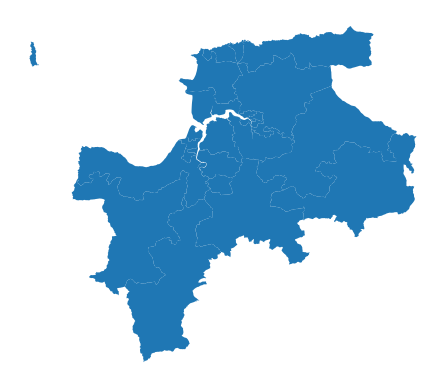

In [10]:
# Filter to MSOA in North Devon or Torridge
la_nd = 'North Devon|Torridge'
shp_nd = shp_full[shp_full['MSOA21NM'].str.contains(la_nd)]
preview_gpd(shp_nd)

932         Bolton
982           Bury
1032    Manchester
1065        Oldham
1094      Rochdale
1123       Salford
1158     Stockport
1194      Tameside
1222      Trafford
1256         Wigan
Name: MSOA21NM, dtype: object


MSOA21CD    MSOA21NM   BNG_E   BNG_N     LONG      LAT  \
932  E02000984  Bolton 001  370496  414294 -2.44755  53.6244   
933  E02000985  Bolton 002  373170  413001 -2.40701  53.6129   
934  E02000986  Bolton 003  371724  412733 -2.42884  53.6104   
935  E02000987  Bolton 004  363867  411815 -2.54749  53.6017   
936  E02000988  Bolton 005  371364  411523 -2.43417  53.5995   

                                 GlobalID  \
932  82d9b947-be60-41bd-8b9e-79b51e0c35d4   
933  f27e68dc-9280-4071-81d9-7d512b6e0ba2   
934  4049a429-43d1-4653-bd79-68213eebb4d5   
935  16d4769e-1e1b-4aab-94c2-16ea6b706e37   
936  ded55317-dc2b-433d-a6cc-cf1f6d38dc0a   

                                              geometry  
932  POLYGON ((371405.500 416301.312, 371471.156 41...  
933  POLYGON ((373358.406 414213.311, 373354.895 41...  
934  POLYGON ((372353.774 413659.877, 372359.218 41...  
935  POLYGON ((364293.969 412767.300, 364319.730 41...  
936  POLYGON ((370954.000 412542.000, 370972.794 41...

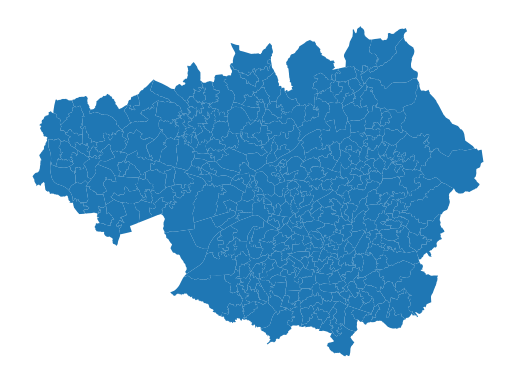

In [11]:
# Filter to MSOA in Greater Manchester
la_gm = ('Bolton|Bury|Manchester|Oldham|Rochdale|Salford|Stockport|' +
         'Trafford|Wigan|Tameside')
shp_gm = shp_full[shp_full['MSOA21NM'].str.contains(la_gm)]
preview_gpd(shp_gm)

4491    Basingstoke and Deane
4512           East Hampshire
4535                Eastleigh
4553                  Fareham
4557                  Gosport
4570                     Hart
4586                   Havant
3435            Isle of Wight
4611               New Forest
6718               Portsmouth
4615                 Rushmoor
6813              Southampton
6815              Test Valley
4651               Winchester
Name: MSOA21NM, dtype: object


MSOA21CD        MSOA21NM   BNG_E   BNG_N     LONG      LAT  \
3370  E02003524  Portsmouth 001  463726  106331 -1.09606  50.8530   
3371  E02003525  Portsmouth 002  465172  105904 -1.07559  50.8490   
3372  E02003526  Portsmouth 003  466581  106095 -1.05555  50.8505   
3373  E02003527  Portsmouth 004  464176  104420 -1.09000  50.8358   
3374  E02003529  Portsmouth 006  466420  104928 -1.05804  50.8401   

                                  GlobalID  \
3370  b6b6f7f7-6629-4fc7-b391-7b4e7b6a10eb   
3371  bf9cffb8-2b2e-4a86-b645-77121374ace8   
3372  11f2351b-6719-4260-b81a-905a031af16b   
3373  56853824-d109-4b2a-98f3-80cf96ef0563   
3374  fe96c309-93dd-4080-ab77-3631a308e09c   

                                               geometry  
3370  POLYGON ((464314.563 106799.789, 464379.992 10...  
3371  POLYGON ((465128.903 106733.811, 465159.188 10...  
3372  POLYGON ((465694.708 106937.791, 465695.689 10...  
3373  MULTIPOLYGON (((462551.375 104750.024, 462551....  
3374  POLYGON ((465862.524 105735.777, 465880.194 10...

/home/amy/.virtualenvs/kailo_symbol/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


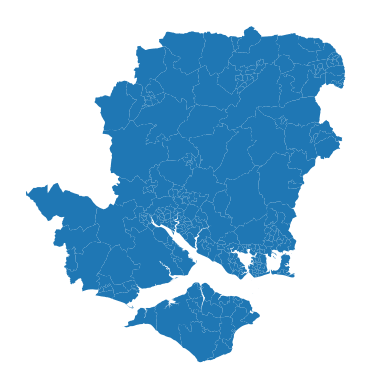

In [12]:
# Filter to MSOA in HIPS
la_hips = ('Basingstoke and Deane|East Hampshire|Eastleigh|Fareham|Gosport|' +
           'Hart|Havant|Isle of Wight|New Forest|Portsmouth|Rushmoor|' + 
           'Southampton|Test Valley|Winchester')
shp_hips = shp_full[shp_full['MSOA21NM'].str.contains(la_hips)]
shp_hips = shp_hips[~shp_hips['MSOA21NM'].str.contains('Hartlepool')]
preview_gpd(shp_hips)

Merge shapefiles into a single geopandas dataframe

(623, 8)


/home/amy/.virtualenvs/kailo_symbol/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

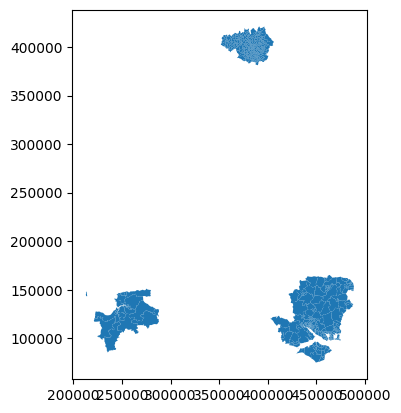

In [13]:
shp_beewell = pd.concat([shp_nd, shp_gm, shp_hips])
print(shp_beewell.shape)
shp_beewell.plot()

In [14]:
# Join the local authority strings
la_beewell = '|'.join([la_nd, la_gm, la_hips])

# Create a list version
la_beewell_list = la_beewell.split('|')
la_beewell_list

['North Devon',
 'Torridge',
 'Bolton',
 'Bury',
 'Manchester',
 'Oldham',
 'Rochdale',
 'Salford',
 'Stockport',
 'Trafford',
 'Wigan',
 'Tameside',
 'Basingstoke and Deane',
 'East Hampshire',
 'Eastleigh',
 'Fareham',
 'Gosport',
 'Hart',
 'Havant',
 'Isle of Wight',
 'New Forest',
 'Portsmouth',
 'Rushmoor',
 'Southampton',
 'Test Valley',
 'Winchester']

### Filter other files to relevant areas

In [15]:
# Filter to local authorities with #BeeWell survey
imd_beewell = imd[imd['local_authority'].isin(la_beewell_list)]

# Preview head of the dataframe
display(imd_beewell.head())

# Print the list of local authorities that those LSOA are part of
imd_beewell['local_authority'].drop_duplicates().sort_values()

msoa_code local_authority  imd_score  imd_msoa_rank  imd_msoa_decile  \
951  E02000984          Bolton   5.686451           6547               10   
952  E02000985          Bolton   8.467447           5952                9   
953  E02000986          Bolton  12.653141           4782                8   
954  E02000987          Bolton  29.730829           1566                3   
955  E02000988          Bolton  32.753429           1254                2   

     imd_msoa_quintile  
951                  5  
952                  5  
953                  4  
954                  2  
955                  1

4571    Basingstoke and Deane
951                    Bolton
986                      Bury
4593           East Hampshire
4606                Eastleigh
4621                  Fareham
4635                  Gosport
4645                     Hart
4656                   Havant
3490            Isle of Wight
1012               Manchester
4670               New Forest
4074              North Devon
1062                   Oldham
3434               Portsmouth
1094                 Rochdale
4693                 Rushmoor
1119                  Salford
3458              Southampton
1149                Stockport
1191                 Tameside
4705              Test Valley
4119                 Torridge
1221                 Trafford
1249                    Wigan
4720               Winchester
Name: local_authority, dtype: object

In [16]:
# Filter to #BeeWell sites
ruc_beewell = ruc[ruc['local_authority'].isin(la_beewell_list)]
ruc_beewell

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority
951   E02000984      Bolton 001  Urban         A1          Bolton
952   E02000985      Bolton 002  Urban         A1          Bolton
953   E02000986      Bolton 003  Urban         A1          Bolton
954   E02000987      Bolton 004  Urban       C1            Bolton
955   E02000988      Bolton 005  Urban         A1          Bolton
...         ...             ...    ...        ...             ...
6770  E02006913  Manchester 056  Urban         A1      Manchester
6771  E02006914  Manchester 057  Urban         A1      Manchester
6772  E02006915  Manchester 058  Urban         A1      Manchester
6773  E02006916  Manchester 059  Urban         A1      Manchester
6774  E02006917  Manchester 060  Urban         A1      Manchester

[612 rows x 5 columns]

## Explore combination of IMD and ruc

**Creation of sets**

Options:
* A single-set of MSOAs matched for all of Northern Devon.
* A set of matched MSOAs for each MSOA in Northern Devon.

To consider:
* Whether the MSOAs in Northern Devon are too diverse.
* Whether a single matched set is relevant when looking on an MSOA-level.
* There are some duplicate matches (but could sample without replacement and then choose next closest).

**Matching of MSOAs**

Some ideas for what you match on re: RUC:
* Whether are rural or urban (so needs to be exact match)
* Which RUC 8-class code they are (so needs to be exact match - or some sort of ranking of what the next most similar code is, which is not defined)
* Proportion of rural LSOAs in each MSOA (each is about 4, 5 LSOAs, so would be 20%, 40%, 60%, etc.)
* Proportion of rural LSOAs in each MSOA, weighted by census population counts
* Proportion of young people who did the survey in each MSOA who are from a rural LSOA (requires counts in rural and urban)

Some ideas for what you match on re: IMD:
* Most similar IMD rank
* Most similar IMD decile
* Most similar IMD quintile

Some ideas of how you combine:
* Either RUC or IMD exact match, and then closest of the other - requires one scale to have limited categories, and one scale to be continuous
* A weighted scale that considers the range of possible values for each, to help determine most similar when traversing two different scales simultaneously - requires both scales to be continuous

In [17]:
# Merge the RUC and IMD data into one dataframe
ruc_imd = pd.merge(ruc_beewell, imd_beewell,
                   on=['msoa_code', 'local_authority'])
ruc_imd.head()

msoa_code   msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
0  E02000984  Bolton 001  Urban         A1          Bolton   5.686451   
1  E02000985  Bolton 002  Urban         A1          Bolton   8.467447   
2  E02000986  Bolton 003  Urban         A1          Bolton  12.653141   
3  E02000987  Bolton 004  Urban       C1            Bolton  29.730829   
4  E02000988  Bolton 005  Urban         A1          Bolton  32.753429   

   imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
0           6547               10                  5  
1           5952                9                  5  
2           4782                8                  4  
3           1566                3                  2  
4           1254                2                  1

In [18]:
# Filter to Northern Devon or not
ruc_imd_nd = ruc_imd[ruc_imd['local_authority'].isin(['North Devon', 'Torridge'])]
ruc_imd_other = ruc_imd[~ruc_imd['local_authority'].isin(['North Devon', 'Torridge'])]

Look for exact matches in terms of rural or urban, and IMD decile. Can see there is only 1 rural IMD 6 in the other areas.

In [19]:
ruc2_imd_count_nd = (ruc_imd_nd[['ruc_2', 'imd_msoa_decile']]
                     .value_counts()
                     .reset_index()
                     .sort_values(['ruc_2', 'imd_msoa_decile'])
                     .rename(columns={'count': 'count_nd'}))
ruc2_imd_count_other = (ruc_imd_other[['ruc_2', 'imd_msoa_decile']]
                        .value_counts()
                        .reset_index()
                        .sort_values(['ruc_2', 'imd_msoa_decile'])
                        .rename(columns={'count': 'count_other'}))
ruc2_imd_counts = pd.merge(ruc2_imd_count_nd, ruc2_imd_count_other,
                           on=['ruc_2', 'imd_msoa_decile'], how='left')
ruc2_imd_counts

ruc_2  imd_msoa_decile  count_nd  count_other
0   Rural                3         1            1
1   Rural                4         4            1
2   Rural                5         2            2
3   Rural                6         2            1
4   Rural                7         1            6
5   Rural                8         1            9
6   Rural                9         1           12
7   Urban                2         2           63
8   Urban                3         2           56
9   Urban                4         3           70
10  Urban                5         2           53
11  Urban                6         1           41
12  Urban                7         1           32

This uses more granular RUC and less granular IMD, and there are six instances with no direct match elsewhere.

In [20]:
ruc8_imd_count_nd = (ruc_imd_nd[['ruc_8_code', 'imd_msoa_quintile']]
                     .value_counts()
                     .reset_index()
                     .sort_values(['ruc_8_code', 'imd_msoa_quintile'])
                     .rename(columns={'count': 'count_nd'}))
ruc8_imd_count_other = (ruc_imd_other[['ruc_8_code', 'imd_msoa_quintile']]
                        .value_counts()
                        .reset_index()
                        .sort_values(['ruc_8_code', 'imd_msoa_quintile'])
                        .rename(columns={'count': 'count_other'}))
ruc8_imd_counts = pd.merge(ruc8_imd_count_nd, ruc8_imd_count_other,
                           on=['ruc_8_code', 'imd_msoa_quintile'], how='left')
ruc8_imd_counts

ruc_8_code  imd_msoa_quintile  count_nd  count_other
0        C1                    1         1         25.0
1        C1                    2         4         41.0
2        C1                    3         3         48.0
3        C1                    4         1         34.0
4         C2                   1         1          NaN
5         C2                   2         1          NaN
6         D1                   3         1          2.0
7         D1                   4         1          8.0
8         D1                   5         1         15.0
9         D2                   2         1          NaN
10        D2                   3         1          NaN
11         E1                  3         1          1.0
12         E1                  4         1          7.0
13         E2                  2         4          NaN
14         E2                  3         1          NaN

Looking for closest matches is difficult. For IMD, it's fine as they are ordered and can look for closest match. However, RUC is not ordered as it has two dimensions - population density of the area, and of the surrounding areas - and the difference between A1 and A2 might be quite different to the size of the difference between C1 and C2.

You could just set it to find MSOA that is either Rural or Urban, and then the closest rank.

In [21]:
for index, row in ruc_imd_nd.iterrows():
    # Filter the other MSOAs to either rural or urban
    df = ruc_imd_other[ruc_imd_other['ruc_2'] == row['ruc_2']]

    # Find the difference between rank of the Devon MSOA and all the other MSOAs
    # and then find the smallest absolute value, which is the closest
    sorted = (df['imd_msoa_rank']-row['imd_msoa_rank']).abs().sort_values().reset_index()
    closest_index = sorted.iloc[0]['index']

    # Find the MSOA with the most similar IMD rank
    display(pd.DataFrame(row).T)
    display(df[df.index == closest_index])

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
412  E02004175  North Devon 001  Urban        C2      North Devon  36.702612   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
412           917               2                 1

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
270  E02001259  Trafford 001  Urban         A1        Trafford  36.773255   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
270            913                2                  1

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
413  E02004176  North Devon 002  Rural        D2      North Devon  21.891597   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
413          2687               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
410  22.244984           2621                4                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
414  E02004177  North Devon 003  Urban        C2      North Devon  26.958366   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
414          1940               3                 2

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
606  E02006912  Manchester 055  Urban         A1      Manchester  26.978671   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
606           1937                3                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
415  E02004178  North Devon 004  Rural         E1     North Devon  10.750341   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
415          5313               8                 4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
576  E02004821  Test Valley 008  Rural         E1     Test Valley   10.89835   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
576           5263                8                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority imd_score  \
416  E02004179  North Devon 005  Rural        D1      North Devon   9.78603   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
416          5597               9                 5

msoa_code                  msoa_name  ruc_2 ruc_8_code  \
438  E02004678  Basingstoke and Deane 004  Rural        D1    

           local_authority  imd_score  imd_msoa_rank  imd_msoa_decile  \
438  Basingstoke and Deane   9.872713           5579                9   

     imd_msoa_quintile  
438                  5

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
417  E02004180  North Devon 006  Rural         E1     North Devon  17.522881   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
417          3532               6                 3

msoa_code  msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
301  E02001290  Wigan 004  Rural        D1            Wigan  17.692431   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301           3499                6                  3

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
418  E02004181  North Devon 007  Urban       C1       North Devon  20.037297   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
418          3036               5                 3

msoa_code   msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
524  E02004768  Havant 007  Urban       C1            Havant  20.039636   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
524           3035                5                  3

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
419  E02004182  North Devon 008  Urban       C1       North Devon  34.882122   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
419          1048               2                 1

msoa_code    msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
178  E02001167  Salford 011  Urban         A1         Salford  34.915228   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
178           1045                2                  1

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
420  E02004183  North Devon 009  Urban       C1       North Devon  18.578687   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
420          3334               5                 3

msoa_code                  msoa_name  ruc_2 ruc_8_code  \
453  E02004693  Basingstoke and Deane 019  Urban       C1     

           local_authority  imd_score  imd_msoa_rank  imd_msoa_decile  \
453  Basingstoke and Deane  18.595499           3329                5   

     imd_msoa_quintile  
453                  3

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority imd_score  \
421  E02004184  North Devon 010  Urban       C1       North Devon  23.53535   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
421          2432               4                 2

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
96  E02001083  Manchester 039  Urban         A1      Manchester  23.524031   

    imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
96           2435                4                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority imd_score  \
422  E02004185  North Devon 011  Rural        D1      North Devon   13.1792   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
422          4623               7                 4

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
534  E02004779  New Forest 001  Rural        D1       New Forest  13.019646   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
534           4667                7                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
423  E02004186  North Devon 012  Urban       C1       North Devon  14.898982   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
423          4146               7                 4

msoa_code msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
60  E02001044  Bury 026  Urban         A1            Bury   14.86146   

    imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
60           4154                7                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
424  E02004187  North Devon 013  Rural        D2      North Devon  21.422327   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
424          2777               5                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
410  22.244984           2621                4                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
425  E02004188  North Devon 014  Rural         E2     North Devon  23.595616   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
425          2423               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
410  22.244984           2621                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
426  E02004220  Torridge 001  Urban       C1          Torridge  22.054292   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
426          2656               4                 2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
391  E02003578  Southampton 030  Urban       C1       Southampton  22.083982   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
391           2650                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
427  E02004221  Torridge 002  Urban       C1          Torridge  16.061896   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
427          3854               6                 3

msoa_code      msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
208  E02001197  Stockport 011  Urban         A1       Stockport  15.888901   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
208           3899                6                  3

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
428  E02004222  Torridge 003  Urban       C1          Torridge  28.880783   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
428          1672               3                 2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
165  E02001154  Rochdale 023  Urban         A1        Rochdale  28.829369   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
165           1681                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
429  E02004223  Torridge 004  Urban       C1          Torridge  24.907183   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
429          2234               4                 2

msoa_code msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
57  E02001041  Bury 023  Urban         A1            Bury  24.941525   

    imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
57           2231                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
430  E02004224  Torridge 005  Rural         E2        Torridge  21.734036   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
430          2719               5                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
410  22.244984           2621                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
431  E02004225  Torridge 006  Rural        D1         Torridge  16.661633   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
431          3705               6                 3

msoa_code  msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
301  E02001290  Wigan 004  Rural        D1            Wigan  17.692431   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301           3499                6                  3

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
432  E02004226  Torridge 007  Rural         E2        Torridge  22.690905   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
432          2558               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
410  22.244984           2621                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
433  E02004227  Torridge 008  Rural         E2        Torridge  26.590534   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
433          1993               3                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
411  29.198628           1632                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
434  E02004228  Torridge 009  Rural         E2        Torridge  26.069368   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
434          2080               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
411  29.198628           1632                3                  2

Need to consider that not all MSOAs may have complete/sufficient data.

Also, the closest match for some MSOAs will be the same (so would need to change to sampling without replacement).

Tried the same exercise but looking at the five closest...

In [22]:
for index, row in ruc_imd_nd.iterrows():
    # Filter the other MSOAs to either rural or urban
    df = ruc_imd_other[ruc_imd_other['ruc_2'] == row['ruc_2']]

    # Find the difference between rank of the Devon MSOA and all the other MSOAs
    # and then find the smallest absolute value, which is the closest
    sorted = (df['imd_msoa_rank']-row['imd_msoa_rank']).abs().sort_values().reset_index()
    closest_index = sorted.iloc[0:5]['index']

    # Find the MSOA with the most similar IMD rank
    display(pd.DataFrame(row).T)
    display(df[df.index.isin(closest_index)])

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
412  E02004175  North Devon 001  Urban        C2      North Devon  36.702612   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
412           917               2                 1

msoa_code      msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
16   E02001000     Bolton 017  Urban         A1          Bolton  36.606929   
22   E02001006     Bolton 023  Urban         A1          Bolton  36.561012   
186  E02001175    Salford 019  Urban         A1         Salford  36.894901   
221  E02001210  Stockport 024  Urban         A1       Stockport  36.805066   
270  E02001259   Trafford 001  Urban         A1        Trafford  36.773255   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
16             922                2                  1  
22             927                2                  1  
186            903                2                  1  
221            911                2                  1  
270            913                2                  1

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
413  E02004176  North Devon 002  Rural        D2      North Devon  21.891597   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
413          2687               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
414  E02004177  North Devon 003  Urban        C2      North Devon  26.958366   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
414          1940               3                 2

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
103  E02001090  Manchester 046  Urban         A1      Manchester  27.070843   
119  E02001106      Oldham 009  Urban         A1          Oldham  27.008317   
249  E02001238    Tameside 010  Urban         A1        Tameside  26.886362   
348  E02003535  Portsmouth 012  Urban       C1        Portsmouth  26.876717   
606  E02006912  Manchester 055  Urban         A1      Manchester  26.978671   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
103           1928                3                  2  
119           1935                3                  2  
249           1949                3                  2  
348           1952                3                  2  
606           1937                3                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
415  E02004178  North Devon 004  Rural         E1     North Devon  10.750341   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
415          5313               8                 4

msoa_code           msoa_name  ruc_2 ruc_8_code local_authority  \
403  E02003590   Isle of Wight 010  Rural        D1    Isle of Wight   
465  E02004706  East Hampshire 010  Rural        D1   East Hampshire   
575  E02004820     Test Valley 007  Rural         E1     Test Valley   
576  E02004821     Test Valley 008  Rural         E1     Test Valley   
597  E02004842      Winchester 014  Rural        D1       Winchester   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
403  11.287215           5156                8                  4  
465  11.056631           5221                8                  4  
575  11.255038           5164                8                  4  
576  10.898350           5263                8                  4  
597  10.390811           5420                8                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority imd_score  \
416  E02004179  North Devon 005  Rural        D1      North Devon   9.78603   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
416          5597               9                 5

msoa_code                  msoa_name  ruc_2 ruc_8_code  \
438  E02004678  Basingstoke and Deane 004  Rural        D1    
439  E02004679  Basingstoke and Deane 005  Rural        D1    
512  E02004754                   Hart 004  Rural        D1    
585  E02004830             Winchester 002  Rural        D1    
594  E02004839             Winchester 011  Rural         E1   

           local_authority  imd_score  imd_msoa_rank  imd_msoa_decile  \
438  Basingstoke and Deane   9.872713           5579                9   
439  Basingstoke and Deane  10.072861           5525                9   
512                   Hart   9.659946           5646                9   
585             Winchester   9.953751           5563                9   
594             Winchester   9.678121           5640                9   

     imd_msoa_quintile  
438                  5  
439                  5  
512                  5  
585                  5  
594                  5

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
417  E02004180  North Devon 006  Rural         E1     North Devon  17.522881   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
417          3532               6                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
540  E02004785     New Forest 007  Rural         E1      New Forest   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
540  14.927985           4138                7                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
418  E02004181  North Devon 007  Urban       C1       North Devon  20.037297   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
418          3036               5                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
86   E02001073     Manchester 029  Urban         A1      Manchester   
254  E02001243       Tameside 015  Urban         A1        Tameside   
394  E02003581  Isle of Wight 001  Urban       C1     Isle of Wight   
505  E02004747        Gosport 007  Urban       C1           Gosport   
524  E02004768         Havant 007  Urban       C1            Havant   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
86   20.115018           3019                5                  3  
254  19.924002           3047                5                  3  
394  19.948052           3042                5                  3  
505  19.913288           3048                5                  3  
524  20.039636           3035                5                  3

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
419  E02004182  North Devon 008  Urban       C1       North Devon  34.882122   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
419          1048               2                 1

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
83   E02001070     Manchester 026  Urban         A1      Manchester   
178  E02001167        Salford 011  Urban         A1         Salford   
188  E02001177        Salford 021  Urban         A1         Salford   
397  E02003584  Isle of Wight 004  Urban       C1     Isle of Wight   
506  E02004748        Gosport 008  Urban       C1           Gosport   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
83   34.695157           1066                2                  1  
178  34.915228           1045                2                  1  
188  34.819393           1055                2                  1  
397  34.639375           1071                2                  1  
506  34.829264           1053                2                  1

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
420  E02004183  North Devon 009  Urban       C1       North Devon  18.578687   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
420          3334               5                 3

msoa_code                  msoa_name  ruc_2 ruc_8_code  \
115  E02001102                 Oldham 005  Urban         A1   
167  E02001156               Rochdale 025  Urban         A1   
381  E02003568            Southampton 020  Urban       C1     
453  E02004693  Basingstoke and Deane 019  Urban       C1     
599  E02006822                 Havant 018  Urban       C1     

           local_authority  imd_score  imd_msoa_rank  imd_msoa_decile  \
115                 Oldham  18.375405           3369                5   
167               Rochdale  18.617802           3326                5   
381            Southampton  18.431131           3361                5   
453  Basingstoke and Deane  18.595499           3329                5   
599                 Havant  18.795598           3295                5   

     imd_msoa_quintile  
115                  3  
167                  3  
381                  3  
453                  3  
599                  3

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority imd_score  \
421  E02004184  North Devon 010  Urban       C1       North Devon  23.53535   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
421          2432               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
17   E02001001         Bolton 018  Urban         A1          Bolton   
96   E02001083     Manchester 039  Urban         A1      Manchester   
242  E02001231       Tameside 003  Urban         A1        Tameside   
396  E02003583  Isle of Wight 003  Urban       C1     Isle of Wight   
564  E02004809       Rushmoor 008  Urban       C1          Rushmoor   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
17   23.583642           2426                4                  2  
96   23.524031           2435                4                  2  
242  23.464294           2447                4                  2  
396  23.682295           2410                4                  2  
564  23.414197           2458                4                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority imd_score  \
422  E02004185  North Devon 011  Rural        D1      North Devon   13.1792   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
422          4623               7                 4

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
398  E02003585  Isle of Wight 005  Rural        D1    Isle of Wight   
534  E02004779     New Forest 001  Rural        D1       New Forest   
577  E02004822    Test Valley 009  Rural         E1     Test Valley   
581  E02004826    Test Valley 013  Rural         E1     Test Valley   
596  E02004841     Winchester 013  Rural         E1      Winchester   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
398  12.901138           4698                7                  4  
534  13.019646           4667                7                  4  
577  12.909265           4696                7                  4  
581  13.650042           4489                7                  4  
596  12.676996           4773                8                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
423  E02004186  North Devon 012  Urban       C1       North Devon  14.898982   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
423          4146               7                 4

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
35   E02001019        Bury 001  Urban         A1            Bury  14.959141   
60   E02001044        Bury 026  Urban         A1            Bury  14.861460   
100  E02001087  Manchester 043  Urban         A1      Manchester  14.828426   
326  E02001315       Wigan 029  Urban         A1           Wigan  15.105135   
565  E02004810    Rushmoor 009  Urban       C1          Rushmoor  14.955133   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
35            4130                7                  4  
60            4154                7                  4  
100           4164                7                  4  
326           4091                7                  4  
565           4132                7                  4

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
424  E02004187  North Devon 013  Rural        D2      North Devon  21.422327   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
424          2777               5                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
425  E02004188  North Devon 014  Rural         E2     North Devon  23.595616   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
425          2423               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
426  E02004220  Torridge 001  Urban       C1          Torridge  22.054292   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
426          2656               4                 2

msoa_code        msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
90   E02001077   Manchester 033  Urban         A1      Manchester  22.025798   
310  E02001299        Wigan 013  Urban         A1           Wigan  22.014447   
334  E02001323        Wigan 037  Urban         A1           Wigan  21.962093   
347  E02003534   Portsmouth 011  Urban       C1        Portsmouth  22.188143   
391  E02003578  Southampton 030  Urban       C1       Southampton  22.083982   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
90            2663                4                  2  
310           2666                4                  2  
334           2674                4                  2  
347           2633                4                  2  
391           2650                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
427  E02004221  Torridge 002  Urban       C1          Torridge  16.061896   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
427          3854               6                 3

msoa_code       msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
208  E02001197   Stockport 011  Urban         A1       Stockport  15.888901   
255  E02001244    Tameside 016  Urban         A1        Tameside  16.324773   
342  E02003529  Portsmouth 006  Urban       C1        Portsmouth  15.866084   
530  E02004775      Havant 014  Urban       C1            Havant  16.284400   
562  E02004807    Rushmoor 006  Urban       C1          Rushmoor  15.824299   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
208           3899                6                  3  
255           3791                6                  3  
342           3907                6                  3  
530           3805                6                  3  
562           3924                6                  3

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
428  E02004222  Torridge 003  Urban       C1          Torridge  28.880783   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
428          1672               3                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
165  E02001154       Rochdale 023  Urban         A1        Rochdale   
302  E02001291          Wigan 005  Urban         A1           Wigan   
323  E02001312          Wigan 026  Urban         A1           Wigan   
382  E02003569    Southampton 021  Urban       C1       Southampton   
407  E02003594  Isle of Wight 014  Urban       C1     Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
165  28.829369           1681                3                  2  
302  29.148782           1640                3                  2  
323  28.963168           1661                3                  2  
382  28.605226           1710                3                  2  
407  28.798890           1686                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
429  E02004223  Torridge 004  Urban       C1          Torridge  24.907183   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
429          2234               4                 2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
57   E02001041      Bury 023  Urban         A1            Bury  24.941525   
147  E02001136  Rochdale 005  Urban         A1        Rochdale  25.013510   
272  E02001261  Trafford 003  Urban         A1        Trafford  24.809341   
280  E02001269  Trafford 011  Urban         A1        Trafford  24.885686   
322  E02001311     Wigan 025  Urban         A1           Wigan  24.964414   

     imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
57            2231                4                  2  
147           2224                4                  2  
272           2248                4                  2  
280           2237                4                  2  
322           2230                4                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
430  E02004224  Torridge 005  Rural         E2        Torridge  21.734036   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
430          2719               5                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
431  E02004225  Torridge 006  Rural        D1         Torridge  16.661633   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
431          3705               6                 3

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
483  E02004725      Eastleigh 014  Rural        D1        Eastleigh   
540  E02004785     New Forest 007  Rural         E1      New Forest   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
483  13.784190           4452                7                  4  
540  14.927985           4138                7                  4

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
432  E02004226  Torridge 007  Rural         E2        Torridge  22.690905   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
432          2558               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
433  E02004227  Torridge 008  Rural         E2        Torridge  26.590534   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
433          1993               3                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2

msoa_code     msoa_name  ruc_2 ruc_8_code local_authority  imd_score  \
434  E02004228  Torridge 009  Rural         E2        Torridge  26.069368   

    imd_msoa_rank imd_msoa_decile imd_msoa_quintile  
434          2080               4                 2

msoa_code          msoa_name  ruc_2 ruc_8_code local_authority  \
301  E02001290          Wigan 004  Rural        D1            Wigan   
405  E02003592  Isle of Wight 012  Rural        D1    Isle of Wight   
406  E02003593  Isle of Wight 013  Rural         E1   Isle of Wight   
410  E02003597  Isle of Wight 017  Rural         E1   Isle of Wight   
411  E02003598  Isle of Wight 018  Rural        D1    Isle of Wight   

     imd_score  imd_msoa_rank  imd_msoa_decile  imd_msoa_quintile  
301  17.692431           3499                6                  3  
405  20.375558           2973                5                  3  
406  18.226992           3391                5                  3  
410  22.244984           2621                4                  2  
411  29.198628           1632                3                  2